In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set_style("white")
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

In [57]:
def get_ads_urls():
    
    urls_list = []
    # define the basic url to crawl on
    basic_url = "https://www.kijiji.ca/b-house-for-sale/ontario/c35l9004"
    
    # loop over the paginated urls
    
    #We prepared an output file that took an hour to process. use the output file attached with the project
    
    for i in range(2):     #To increase accuracy increase the range 
                            #Increasing range increase the wait time
                            #If you dont want to wait run the fist block in Preprocessing & Cleansing
        # get the page url
        url = basic_url+str(i)
        
        # get the request response
        r  = requests.get(url)
        data = r.text
        
        # transform it to bs object
        soup = BeautifulSoup(data, "lxml")
        
        # loop over page links 
        for section in soup.findAll('section'):
            a = section.findAll('a')[0] 
            if (a.get('href')).find("/vip/") == -1:
                urls_list.append('https://www.kijiji.ca' + a.get('href'))

    
    df = pd.DataFrame(data={"url": urls_list})
    df.to_csv("ads_urls.csv", sep=',',index=False)


In [58]:
get_ads_urls()

In [ ]:
def scrapData(ad_url):
    r = requests.get(ad_url)
    data = r.text
    soup = BeautifulSoup(data, "html.parser")
    target_component = soup.findAll("span", itemprop="name")
    price = soup.findAll("span", {'class': 'currentPrice-441857624'})
    bedRoom = soup.findAll("dd", {'class': 'attributeValue-2574930263'})
    # create a list that will hold our component data
    results = []
    
    for i in target_component:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    for i in bedRoom:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    for i in price:
        results.append(''.join(i.findAll(text=True)).replace('\n',''))
    
    return results

In [ ]:
def dataToCSV(data):
    with open("output.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

In [ ]:
 #read the saved urls file as a dataframe 
urls_data = pd.read_csv("ads_urls.csv")

# create  a list that will hold the final data
final_result = []
i = 1

# loop over the dataframe
for index, row in urls_data.iterrows():
    final_result.append(scrapData(row['url']))

print('Scrapping data finished')

# now that we have all the data we can write it in a csv file
# dataToCSV(final_result)

Scrapping data finished


In [ ]:
# set the column names
#Prov, City, Type, Sale/Rent, Type1, bedroom, bathroom, sqft, price
# Ontario,Toronto (GTA),Markham / York Region,Real Estate,For Sale,Condos for Sale in Markham / York Region,1 bedroom and den,1 bathroom,"$450,000.00"

colnames=['Province', 'City', 'Area', 'Type', 'Sale/Rent', 'Type1', 'Bedroom', 'Bathroom', 'SqFt','Price'] 

# read the csv file as a dataframe
df = pd.read_csv("output.csv", sep=",", names=colnames, header=None)

# let's get some simple vision on our dataset
df.head()

,Province,City,Area,Type,Sale/Rent,Type1,Bedroom,Bathroom,SqFt,Price


In [ ]:
df = df.drop(columns=['Province', 'Area', 'Type', 'Sale/Rent', 'Type1'])
#df = df.dropna(subset = ['Price', 'Bedroom', 'Bathroom', 'SqFt'])

df['Bedroom'] = df['Bedroom'].str.replace('bedrooms', '')
df['Bedroom'] = df['Bedroom'].str.replace('bedroom', '')
df['Bedroom'] = df['Bedroom'].str.replace('and', '')
df['Bedroom'] = df['Bedroom'].str.replace('den', '')
df['Bedroom'] = df['Bedroom'].str.replace(' ', '')
df['Bathroom'] = df['Bathroom'].str.replace('bathrooms', '')
df['Bathroom'] = df['Bathroom'].str.replace('bathroom', '')


df['SqFt'] = df['SqFt'].str.replace(',', '')
df['SqFt'] = df['SqFt'].str.replace(' ', '')

df.Bedroom = pd.to_numeric(df.Bedroom, errors = 'coerce', downcast = 'integer')
df.Bathroom = pd.to_numeric(df.Bathroom, errors = 'coerce', downcast = 'integer')
df.SqFt = pd.to_numeric(df.SqFt, errors = 'coerce', downcast = 'integer')
#df = df.dropna(subset = ['SqFt'])

In [ ]:
df.Price = df.Price.str.replace(',','')
df.Price = df.Price.str.replace(' ','')
df.Price = df.Price.str.replace('$','')
df.Price = pd.to_numeric(df.Price, errors = 'coerce', downcast = 'integer')
df.head()

,City,Bedroom,Bathroom,SqFt,Price


In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
df.head()

,City,Bedroom,Bathroom,SqFt,Price


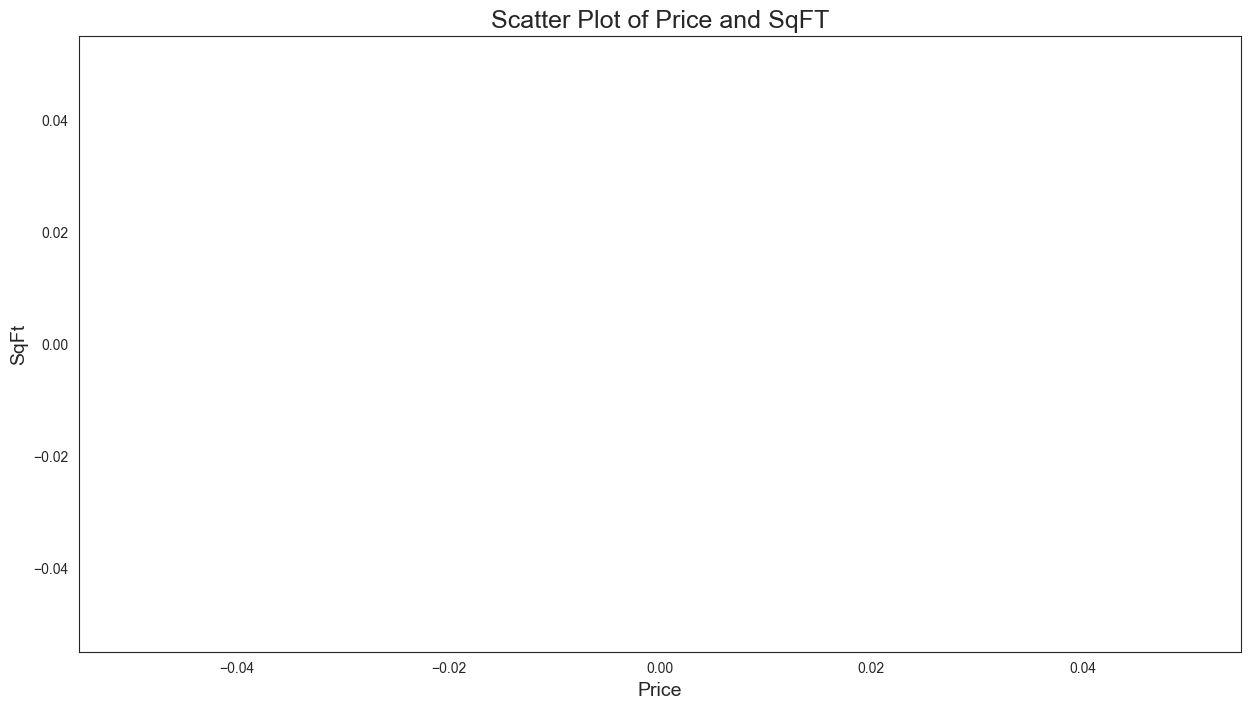

In [ ]:
# here we set the figure size to 15x8
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.Price, df.SqFt)
plt.xlabel("Price", fontsize=14)
plt.ylabel("SqFt", fontsize=14)
plt.title("Scatter Plot of Price and SqFT",fontsize=18)
plt.show()

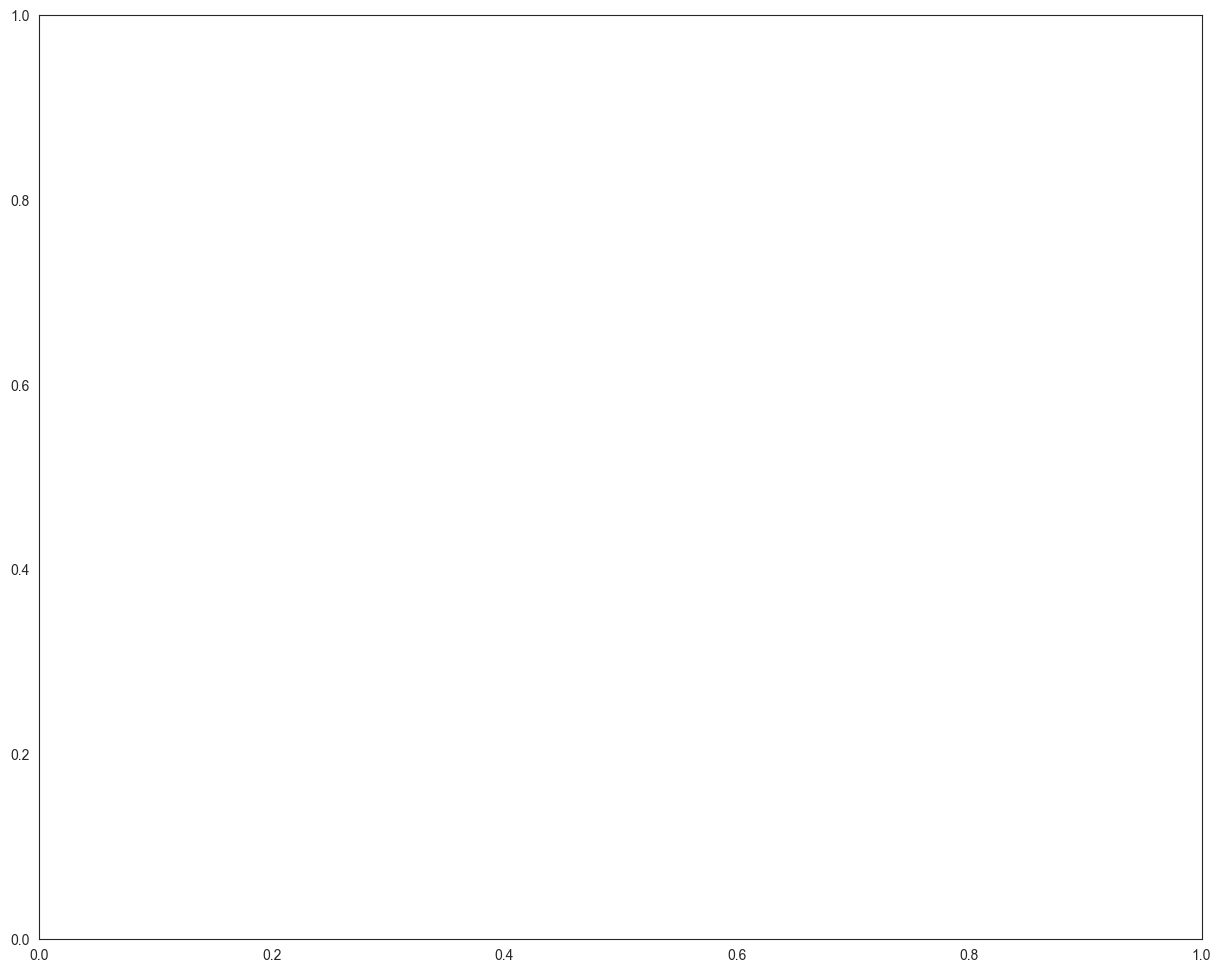

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
sns.stripplot(data = df, x='Price', y='Bedroom', jitter=.1, orient='h')
plt.show()

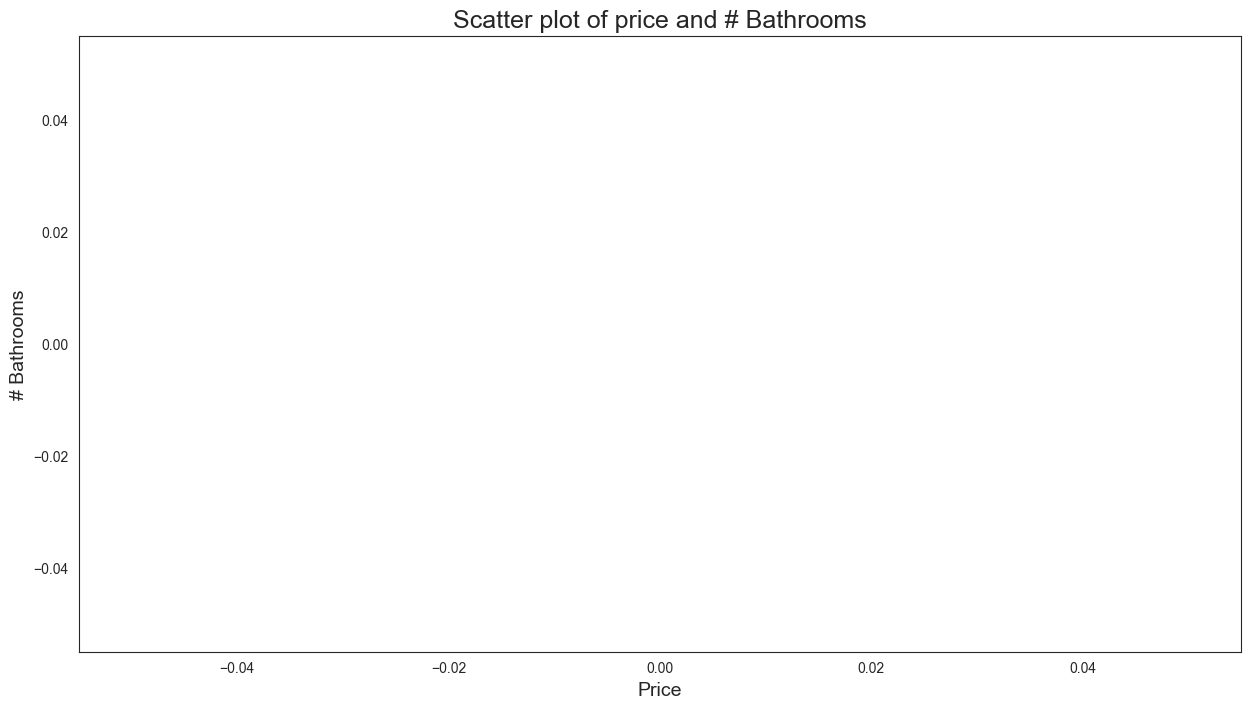

In [ ]:
plt.figure(figsize=(15, 8))
# plot two values price per year_model
plt.scatter(df.Price, df.Bathroom, c='orange', marker='x')
plt.xlabel("Price", fontsize=14)
plt.ylabel("# Bathrooms", fontsize=14)
plt.title("Scatter plot of price and # Bathrooms",fontsize=18)
plt.show()

In [ ]:
print('The number of unique cities are: ',len(df.City.unique()))

The number of unique cities are:  0


IndexError: index 0 is out of bounds for axis 0 with size 0

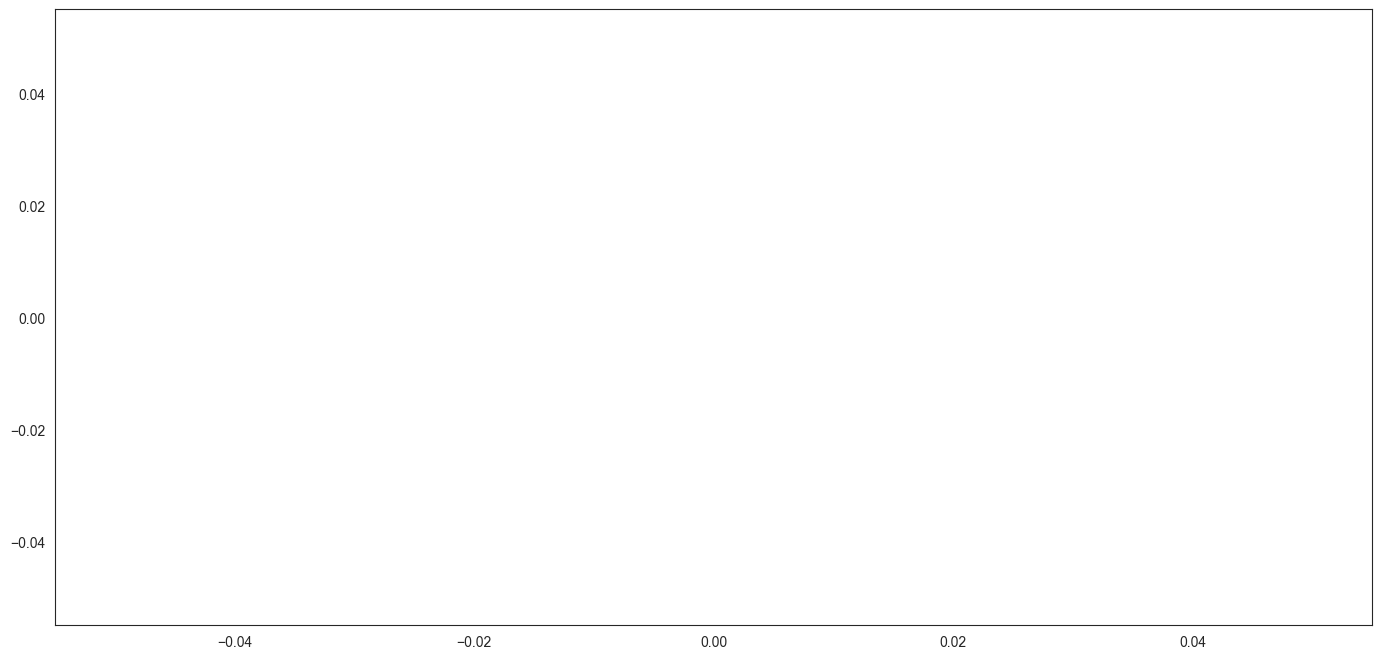

In [ ]:
plt.figure(figsize=(17,8))
df.City.value_counts().nlargest(20).plot(kind='barh')
plt.xlabel('City Frequency')
plt.title("Frequency of TOP 20 Brand distribution",fontsize=18)
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(10, 40))
sns.stripplot(data = df, x='Bathroom', y='Price', jitter=.5, orient='h')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(8,20))
sns.violinplot(data = df, x='Price', y='Bedroom', orient='h')

plt.show()

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))
# Compute the correlation matrix
corr = df.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation matrix', 
          fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize=(17,8))
df.City.value_counts().nlargest(20).plot(kind='bar')
plt.xlabel('City Frequency')
plt.title("Frequency of TOP 20 city distribution",fontsize=18)
plt.show()

In [ ]:
## create a dataframefor testing
data = df[df.Price < 400000]
data.head()


In [ ]:
print(len(data))
print(len(df))

In [ ]:
X = data[['SqFt', 'Bathroom', 'Bedroom', 'City']]
Y = data.Price
X = pd.get_dummies(data=X)

In [ ]:
X.head()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 42)

In [ ]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

In [ ]:
from sklearn.metrics import r2_score
print('Variance score: %.2f' % r2_score(Y_test, predicted))

In [ ]:
rmse_l = []
num = []
for n in range(1, 2):
    knn = neighbors.KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, Y_train)
    predicted = knn.predict(X_test)
    rmse_l.append(np.sqrt(mean_squared_error(Y_test, predicted)))
    num.append(n)

In [ ]:
df_plt = pd.DataFrame()
df_plt['rmse'] = rmse_l
df_plt['n_neighbors'] = num
ax = plt.figure(figsize=(15,7))
sns.barplot(data = df_plt, x = 'n_neighbors', y = 'rmse')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)
predicted = dtr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)

print('Variance score: %.2f' % r2_score(Y_test, predicted))


In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

predicted = regr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(Y_test, predicted))
print('RMSE:')
print(rmse)


In [ ]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

r_sq = []
deep = []
mean_scores = []

for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss ='ls', max_depth=n)
    gbr.fit (X, Y)
    deep.append(n)
    r_sq.append(gbr.score(X, Y))
    mean_scores.append(cross_val_score(gbr, X, Y, cv=2).mean())

In [ ]:
plt_gbr = pd.DataFrame()

plt_gbr['mean_scores'] = mean_scores
plt_gbr['depth'] = deep
plt_gbr['R²'] = r_sq

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='R²')
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data = plt_gbr, x='depth', y='mean_scores')
plt.show()

In [ ]:
X_test

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit (X_train, Y_train)
predicted = gbr.predict(X_test)
residual = Y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

rmse = np.sqrt(mean_squared_error(Y_test, predicted))
scores = cross_val_score(gbr, X, Y, cv=2)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

In [ ]:
print('Variance score: %.2f' % r2_score(Y_test, predicted))

In [ ]:
A = Y_test.reshape(-1, 1)
B = predicted.reshape(-1, 1)

In [ ]:
plt.rcParams['figure.figsize'] = 16,12
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Price: real vs predicted")
plt.ylabel("Price")
plt.xticks(())
plt.show()

In [ ]:
user_input = {'Bedroom':4, 'Bathroom':2, 'SqFt':3000, 'City':'Edmonton Area'}

def input_to_one_hot(data):
    # initialize the target vector with zero values
    enc_input = np.zeros(33)
    # set the numerical input as they are
    enc_input[0] = data['SqFt']
    enc_input[1] = data['Bathroom']
    enc_input[2] = data['Bedroom']
    
    cities = df.City.unique()
    
    redefinded_user_input = 'City_'+data['City']
     
    city_column_index = X.columns.tolist().index(redefinded_user_input)
    mark_column_index = X.columns.tolist().index(redefinded_user_input)
    enc_input[mark_column_index] = 1
    
    return enc_input


In [ ]:
print(input_to_one_hot(user_input))

In [ ]:
a = input_to_one_hot(user_input)
finalPrice = gbr.predict([a])
print("the best price for this specifications is $", finalPrice)
